In [1]:
import pandas as pd
from itertools import islice
import matplotlib.pyplot as plt

In [12]:
#Classe degli indicatori che ci permette di inizializzare il dataframe data una squadra in input

##  Classe Indicators utilizzata per contener einformazioni su Team (= squadra scelta)  ##
## __init__: inizializza le varie istanze dell'oggetto, che poi saranno gli indicatori di Team ##

class Indicators:

    def __init__(self,DataFrame,TeamChosen):
        self.Team = TeamChosen
        self.TeamMatches = DataFrame.loc[((DataFrame.home_team == self.Team) | (DataFrame.away_team == self.Team)) & (DataFrame.tournament == "FIFA World Cup")].copy()
        #inizializziamo gli indicatori di vittorie, sconfitte e pareggi
        self.wins = len(self.TeamMatches[((self.TeamMatches.home_team == self.Team) & (self.TeamMatches.home_score > self.TeamMatches.away_score)) | ((self.TeamMatches.away_team == self.Team) & (self.TeamMatches.home_score < self.TeamMatches.away_score))].index)
        self.loses = len(self.TeamMatches[((self.TeamMatches.home_team == self.Team) & (self.TeamMatches.home_score < self.TeamMatches.away_score)) | ((self.TeamMatches.away_team == self.Team) & (self.TeamMatches.home_score > self.TeamMatches.away_score))].index)
        self.drafts = len(self.TeamMatches[self.TeamMatches.home_score == self.TeamMatches.away_score].index)
        goals_home = self.TeamMatches[['date','home_score','away_score']][(self.TeamMatches.home_team == self.Team)]
        goals_away = self.TeamMatches[['date','away_score','home_score']][(self.TeamMatches.away_team == self.Team)]

        goals_home.columns = ['date','goals_scored','goals_conceded']
        goals_away.columns = ['date','goals_scored','goals_conceded']
        
        frames_goals = [goals_home,goals_away]
        self.goals = pd.concat(frames_goals).sort_index()
        #Convertiamo da obj a datetime per poi poter andare a fare il groupby sulla data nel metodo  plotData()
        self.goals['date'] = pd.to_datetime(self.goals['date'])
        #Calcoliamo media dei goal fatti e subiti
        self.meanScores = self.goals['goals_scored'].mean()
        self.meanConceded = self.goals['goals_conceded'].mean()

    def printData(self):
        print("Wins : " + str(self.wins))
        print("Loses : " + str(self.loses))
        print("Drafts : " + str(self.drafts))
        print("Sum of W+L+D : " + str(self.wins+self.loses+self.drafts))
        print("The mean of the scores made by the team : " + str(self.meanScores))
        print("The mean of the scores conceded by the team : " + str(self.meanConceded))


    ## plotData(): metodo utilizzato per graficare il numero dei gol fatti e subiti di Team per anno 
    def plotData(self):
        self.goals['goals_difference'] = self.goals['goals_scored'] - self.goals['goals_conceded']
        perYearPlot = self.goals.groupby(self.goals.date.dt.year).sum()
        perYearPlot.reset_index().plot(kind = "line", x="date", y="goals_scored", label="Goal Scored")
        perYearPlot.reset_index().plot(kind = "line", x="date", y="goals_conceded", label="Goal Conceded")
        perYearPlot.reset_index().plot(kind = "line", x="date", y="goals_difference", label="Goal Difference")
        plt.show()
    
    ## metodi getter ##
    def getData(self):
        return self.wins,self.loses,self.drafts,self.meanScores,self.meanConceded
    def getMeanScores(self):
        return self.meanScores
    def getMeanConceded(self):
        return self.meanConceded
    def getWins(self):
        return self.wins
    def getLoses(self):
        return self.loses
    def getNumMatchesPlayed(self):
        return self.wins + self.drafts + self.loses
    def getTeamMatches(self):
        return self.TeamMatches

    ## isBetter(): metodo utilizzato per paragonare Team con gli indicatori di altre squadre (indicatori in formato tupla) ##
    ## paragone che viene eseguito per singolo indicatore:
    #   - wins: numero vittorie
    #   - loses: numero sconfitte
    #   - attack: media gol fatti per partita
    #   - defense: media gol subiti per partita
    
    def isBetter(self, otherTeamIndicators, parameter="wins"):
        if(parameter == "wins"):
            return self.wins >= otherTeamIndicators[0]

        if(parameter == "loses"):
            return self.wins <= otherTeamIndicators[1]

        if(parameter == "attack"):
            return self.meanScores >= otherTeamIndicators[3]

        if(parameter == "defense"): 
            return self.meanConceded <= otherTeamIndicators[4]
    pass


Wins : 45
Loses : 17
Drafts : 21
Sum of W+L+D : 83
The mean of the scores made by the team : 1.5421686746987953
The mean of the scores conceded by the team : 0.927710843373494


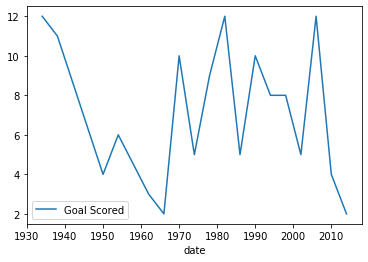

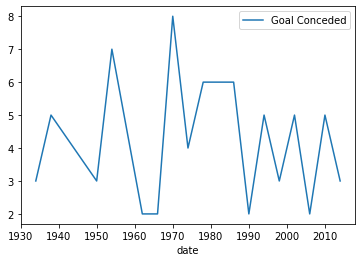

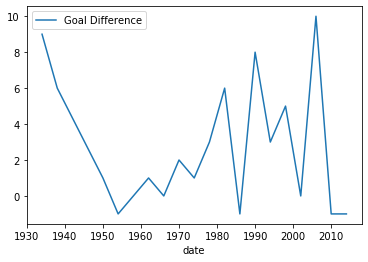

In [13]:
###########################################################################
##  Analisi statistiche su <TeamName> nella storia della FIFA World CUP  ##
###########################################################################

# Dataframe con tutte le partite di tutte le nazionali #
worldFootball = pd.read_csv("results.csv")

# Vengono filtrate tutte e solo quelle della FIFA World Cup #
worldFootball = worldFootball[worldFootball.tournament == "FIFA World Cup"]

# Selezione team su cui eseguire analisi statistiche #
TeamName = "Italy"

# Vengono reperiti gli indicatori di Team e successivamente visualizzati e graficati #
Team = Indicators(worldFootball,TeamName)

Team.printData()

Team.plotData()

In [15]:
#################################################
##   Confronto di Team con le altre squadre    ##
#################################################
# Metodi di confronto: 
#   - per trovare le squadre migliori in assoluto viene stilata una classifica
#     di tutte le squadre che hanno partecipato alla FWC prendendo in considerazione 
#     tutte le partite di tutta la storia (3 punti per vittoria, 1 punto per pareggio e 0 per sconfitta)
#     [Metodo ispirato dallo stesso metodo di confronto utilizzato anche sulla pagina dei mondiali di calcio di Wikipedia]
#   
#   -  gli indicatori delle squadre vengono confrontati singolarmente, visualizzando
#      tutte le squadre che hanno l'indicatore x migliore di Team, con annessi anche dati che contestualizzino
#      l'indicatore. (Ad esempio nelle medie gol fatti/subiti è giusto tenere conto anche delle partite giocate
#      in quanto il confronto con le squadre che hanno giocato un numero di partite molto lontano da quello di Team
#      potrebbe risultare fazioso)#


# Generazione dataframe con tutte le squadre che hanno partecipato a FWC #
# preleva da sia home_team che away_team perché potrebbero esserci squadre che han giocato solo una volta #


allTeams_home = worldFootball[['home_team']].drop_duplicates()
allTeams_away = worldFootball[['away_team']].drop_duplicates()

allTeams_away.columns = ['team']
allTeams_home.columns = ['team']

allTeams = pd.concat([allTeams_away, allTeams_home]).drop_duplicates()
